<a href="https://colab.research.google.com/github/petitdej-num/AperoDeepLearning/blob/master/cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Introduction au _machine learning_ (et au _deep learning_)


### Le machine learning, ce n'est pas que  pour les autres ! Un exemple simple et ludique !




## La preuve par l'exemple : Classification automatique d'images avec un peu de Deep Learning simplifié !


### Si on peut faire ça en peu de temps, imaginez le potentiel sur nos propres données, avec un projet de quelques semaines ou de quelques mois, avec des compétences métiers et des solides compétences de traitement de la donnée.

Cette page web est un notebook _Jupyter_ qui permet d'exécuter du code sur un serveur distant. On lance des calculs sur le _cloud_  ! La démarche est simplifiée pour tenir en format atelier de 30 min. Pour un notebook plus complet, avec plus de propos explicatifs et plus d'exemples,  voir  https://notebooks.azure.com/jetzgetzlos-POC/libraries/POC-cat-classif/html/POC-cat.ipynb (notebook complet de l'atelier SGD MTES de novembre 2017)

**Ne vous formalisez pas sur le code ou sur les aspects trop théoriques du machine learning** : l'idée est de maniper un peu, de voir qu'il est possible de lancer des modèles avec peu de lignes de codes, et non de devenir un expert en Machine learning. Donc pas de panique ! L'atelier sera accompagné d'explications orales et de quelques slides imagés pour comprendre le fonctionnement global.

## La preuve par l'exemple : soyons fous, 50000 images, 10 classes

#### Pourquoi Python ?

Parce que Python offre plus de bibliothèques DeepLearning ... - désolé pour les fans de R :-)

#### Les données

On va utiliser ici la bibliothèque d'images CIFAR 10 (https://www.cs.toronto.edu/~kriz/cifar.html) composée de 60000 images 32x32 avec 10 classes d'images (6000 images par classe).

![CIFAR](https://i0.wp.com/appliedmachinelearning.blog/wp-content/uploads/2018/03/cifar2.jpg?resize=427%2C325&ssl=1)

Ces données ont fait l'objet d'un concours de datascience sur Kaggle : https://www.kaggle.com/c/cifar-10



#### Les bibliothèques utilisées : Keras & Tensorflow 

On pourrait bien sûr tout développer nous-même mais nous n'aurions pas le temps dans la session de 30 minutes et il faudrait pour celà approfondir certains aspects théoriques. Il convient plutôt d'utiliser des bibliothèques existantes. La plus connue est **Tensorflow**, bibliothèque libre issue du laboratoire Google Brain. Nous allons aussi utiliser la bibliothèque **Keras** qui permet de masquer la complexité de Tensorflow en offrant une interface de plus haut niveau.



#### Etape 1, charger les données



In [0]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import keras
from keras.datasets import cifar10
from matplotlib import pyplot as plt
#from scipy.misc import toimage
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dropout
from keras.utils import np_utils
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing.image import ImageDataGenerator

from keras.constraints import maxnorm
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers import Dropout
from keras.layers import Flatten


from IPython.display import SVG
from sklearn.metrics import confusion_matrix
from PIL import Image


Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


In [0]:
# On charge les données ; il y a un dataset pour l'apprentissage et un autre pour les tests
# en toute rigueur il faudrait couper le dataset en 2 pour le dev-test et le test ...
(X_train_origin, Y_train_origin), (X_test_origin, Y_test_origin) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [0]:

labels = ['avion', 'auto', 'oiseau','chat','cerf','chien','grenouille','cheval','navire','camion']

Chaque image est accompagnée d'un label qui indique sa nature (sa _classe_). L'objectif de la démarche est de construire un modèle qui va apprendre des données d'apprentissage (les images stockées dans la variable `X_train_origin` et les labels dans `Y_train_origin`). Ce modèle sera appliqué aux images de tests (`X_test`) pour _prédire_ leurs classes. Les prédictions seront ensuite comparées aux labels connus des images de test (`Y_test`) afin d'estimer la qualité du modèle.

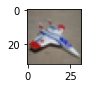

<Figure size 2304x2304 with 0 Axes>

Label: [0]-avion


In [0]:
# On affiche la 30ième image et son label
plt.rcParams["figure.figsize"] = (1,1)

index = 30
plt.imshow(Image.fromarray(X_train_origin[index]),)
#plt.imshow(toimage(X_train_origin[index]),)
plt.figure(figsize=(32,32))
plt.show()
print("Label: "+ str(Y_train_origin[index]) + "-" + str(labels[int(Y_train_origin[index])]))


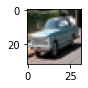

Label: [1]-auto


In [0]:
# On affiche la 32ième image et son label
index = 32
plt.imshow(Image.fromarray(X_train_origin[index]),)
plt.show()
print("Label: "+ str(Y_train_origin[index]) + "-" + str(labels[int(Y_train_origin[index])]))


#### Comprendre les données

Quelle est la taille des variables `X_train`, `Y_train`, `X_test`, `Y_test` ?


In [0]:
print(X_train_origin.shape)

(50000, 32, 32, 3)


In [0]:
print(Y_train_origin.shape)

(50000, 1)


In [0]:
print(X_test_origin.shape)

(10000, 32, 32, 3)


In [0]:
print(Y_test_origin.shape)

(10000, 1)


Il y a 50000 images d'apprentissage et 10000 images de test.

Les labels sont des vecteurs colonnes (des vecteurs). Le label de l'image n°i est `Y_train[i]`


Chaque image est de taille (32, 32, 3). Il s'agit d'images 32*32 avec 3 niveaux de couleur (RVB)
![image.png](https://raw.githubusercontent.com/rst-analytics/atelier-ml/master/Capture2.JPG) 

(source Deeplearning.ai, Andrew NG)


Affichons d'ailleurs l'image n°30 pour s'en convaincre 

In [0]:
print(X_train_origin[30])

[[[126 118 110]
  [122 115 108]
  [126 119 111]
  ...
  [124 118 106]
  [120 114 102]
  [117 111  99]]

 [[122 115 107]
  [119 112 104]
  [121 114 106]
  ...
  [124 118 106]
  [122 116 104]
  [117 111  99]]

 [[122 115 107]
  [121 114 106]
  [121 114 106]
  ...
  [126 120 108]
  [123 117 105]
  [121 115 103]]

 ...

 [[126 118 107]
  [126 118 107]
  [128 120 109]
  ...
  [133 125 114]
  [122 114 103]
  [114 106  95]]

 [[125 117 106]
  [126 118 107]
  [127 119 108]
  ...
  [128 120 109]
  [121 113 102]
  [114 106  95]]

 [[123 115 104]
  [123 115 104]
  [126 118 107]
  ...
  [128 119 109]
  [126 118 107]
  [121 113 102]]]


#### Transformons nos images en vecteurs ! (pas forcément très malin, mais il faut bien commencer ...

L'idée est de transformer chaque image en un seul vecteur colonne, en concaténant les 3 matrices en une seule colonne
![image.png](https://raw.githubusercontent.com/rst-analytics/atelier-ml/master/Capture4.JPG) (source Deeplearning.ai, Andrew NG)

L'idée est de transformer notre matrice (50000, 32, 32, 3) en une matrice (50000, 32x32x3) c'est-à-dire en une matrice (50000, 3072)


In [0]:
m_train = X_train_origin.shape[0] #Nombre d'images d'apprentissage
X_train = X_train_origin.reshape(m_train, -1)

m_test = X_test_origin.shape[0] #Nombre d'images de test
X_test = X_test_origin.reshape(m_test, -1)

print(X_train.shape)
print(X_test.shape)

(50000, 3072)
(10000, 3072)


#### Normalisons les données

Une traitement classique de _preprocessing_ des données en machine learning est de centrer et normaliser les données (on soustrait la moyenne et on divise par l'écart type). En traitement d'images, une autre technique efficace (plus simple et qui marche aussi bien) est de diviser l'ensemble des valeurs des pixels par 255 (la valeur maximale possible).

https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c


![image.png](https://raw.githubusercontent.com/rst-analytics/atelier-ml/master/index.png) 

(Source : Hands-On Machine Learning with Scikit-Learn & TensorFlow, A. Guedon)

In [0]:
X_train = X_train/255
X_test = X_test/255

### Transformons le vecteur de label en matrice

L'idée est d'avoir 10 colonnes de labels par image (1 colonne pour chaque classe). C'est une astuce utile pour la suite. 
Ex : Si la classe de l'image n°i est la classe 7, on rempli la ligne i de la nouvelle matrice par des 0 sauf la colonne 6 qui contient 1. En effet, on commence à numéroter à 0 donc la 7ième colonne est la colonne n°6. 

In [0]:
num_classes = 10
Y_train = np_utils.to_categorical(Y_train_origin)
Y_test = np_utils.to_categorical(Y_test_origin)
Y_train.shape

(50000, 10)

In [0]:
print(Y_train_origin[56,]) #Label de l'image 56
print(Y_train[56])
print(str(labels[int(Y_train_origin[56])]))

[5]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
chien


#### Reproduisons l'aléatoire

L'algorithme va générer des valeurs initiales aléatoires pour les paramètres à estimer. La génération de nombres aléatoires n'est pas vraiment aléatoire sur un ordinateur ! Et il est important de pouvoir reproduire nos tests. Pour cela, on paramètre le seed qui est un chiffre qui permet d'initialiser le générateur de chiffres aléatoires ! Sur cette base, l'ordinateur générera des nombres aléatoires mais on pourra reproduire et retrouver ces chiffres par la suite (en théorie). On pourra regénérer en effet exactement les mêmes séquences de chiffres aléatoires.

In [0]:
#Set seed
seed = 3124
np.random.seed(seed)

#### Premier réseau de neurone très simple (3 couches de 3 neurones)
Pourquoi 3 couches de 3 neurones ? Et bein, pourquoi pas ! Il faut bien tester sur un premier modèle, non ?
On pourrait faire 4 couches de respectivement 16, 32, 16 et 8 neurones. On peut faire ce qu'on veut !

![image.png](https://raw.githubusercontent.com/rst-analytics/atelier-ml/master/nn33.jpg)

In [0]:
model = Sequential()
model.add(Dense(units=3, input_dim=3072))   #3072 = taille de l'image en entrée = 32*32*3
model.add(Activation('relu')) # Fonction d'activation non linéaire
model.add(Dense(units=3))
model.add(Activation('relu'))
model.add(Dense(units=3))
model.add(Activation('relu'))
model.add(Dense(units=num_classes)) #En sortie, 10 outputs, une sortie par classe possible 
model.add(Activation('softmax'))   

#La fonction softmax revoie la probabilité que l'image en entrée soit de la classe i
#(i allant de 0 à 9)

model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy,metrics=['accuracy'])
#Adam = Algorithme très efficace d'optimisation ! Pour plus de détails : https://arxiv.org/pdf/1412.6980   ;-)
# On utilise la fonction de coût entropie croisée

print(model.summary())

#SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 3)                 9219      
_________________________________________________________________
activation_13 (Activation)   (None, 3)                 0         
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 12        
_________________________________________________________________
activation_14 (Activation)   (None, 3)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 12        
_________________________________________________________________
activation_15 (Activation)   (None, 3)                 0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)               

Notez qu'il y a 9283 paramètres à résoudre pour le réseau de neurones.


Lançons la phase d'apprentissage. Il s'agit d'un processus itératif : on lance 10 itérations. On pourrait lancer l'algorithme et l'arrêter lorsqu'il ne s'améliore plus. On choisit ici arbitrairement 10 époques.
On calcule progressivement l'ensemble des éléments, à chaque époque, en prenant les données d'apprentissage par paquet (batch) de 32 photos.

In [0]:
training = model.fit(X_train, Y_train, epochs=10, batch_size=32)

Epoch 1/10
50000/50000 [==============================] - 3s 66us/step - loss: 2.1816 - accuracy: 0.1647
Epoch 2/10
50000/50000 [==============================] - 3s 65us/step - loss: 2.0750 - accuracy: 0.1904
Epoch 3/10
50000/50000 [==============================] - 3s 64us/step - loss: 2.0467 - accuracy: 0.1940
Epoch 4/10
50000/50000 [==============================] - 3s 64us/step - loss: 2.0398 - accuracy: 0.1991
Epoch 5/10
50000/50000 [==============================] - 3s 64us/step - loss: 2.0382 - accuracy: 0.1983
Epoch 6/10
50000/50000 [==============================] - 3s 64us/step - loss: 2.0356 - accuracy: 0.2006
Epoch 7/10
50000/50000 [==============================] - 3s 66us/step - loss: 2.0331 - accuracy: 0.2013
Epoch 8/10
50000/50000 [==============================] - 3s 65us/step - loss: 2.0323 - accuracy: 0.2031
Epoch 9/10
50000/50000 [==============================] - 3s 63us/step - loss: 2.0287 - accuracy: 0.2041
Epoch 10/10
50000/50000 [==============================

pas terrible (mais c'est mieux que le hasard). Ca veut dire ici, que le modèle a permis de classifier correctement 20 % des données d'apprentissage (donc les données avec lesquelles il a appris). 


Regardons ce que donne le modèle sur les données de test, c'est-à-dire les données que le modèle n'a jamais vues :

In [0]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print(scores[1]*100)

20.559999346733093


Pareil; 20%; pas terrible !!

####  Essayons sur un gros réseau de neurones (On fait du deep learning, après tout !!)

Le deep learning, c'est la technique consistant à utiliser des gros réseaux de neurones. On va donc en utiliser un gros ; par exemple celui-ci.

In [0]:
# Create the model
model = Sequential()
model.add(Dense(units=128, input_dim=3072))
model.add(Activation('relu'))
model.add(Dense(units=128))
model.add(Activation('relu'))
model.add(Dense(units=64))
model.add(Activation('relu'))
model.add(Dense(units=32))
model.add(Activation('relu'))
model.add(Dense(units=32))
model.add(Activation('relu'))
model.add(Dense(units=16))
model.add(Activation('relu'))
model.add(Dense(units=num_classes))
model.add(Activation('softmax'))

model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy,metrics=['accuracy'])
print(model.summary())

#SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))






Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 128)               393344    
_________________________________________________________________
activation_17 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               16512     
_________________________________________________________________
activation_18 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                8256      
_________________________________________________________________
activation_19 (Activation)   (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 32)               

On a un peu plus de paramètres à établir (422K) ... Essayons.

In [0]:
model.fit(X_train, Y_train, epochs=10, batch_size=32)

Epoch 1/10
50000/50000 [==============================] - 15s 300us/step - loss: 2.0251 - acc: 0.2427
Epoch 2/10
50000/50000 [==============================] - 15s 291us/step - loss: 1.7867 - acc: 0.3505
Epoch 3/10
50000/50000 [==============================] - 15s 296us/step - loss: 1.7146 - acc: 0.3785
Epoch 4/10
50000/50000 [==============================] - 15s 302us/step - loss: 1.6680 - acc: 0.3998
Epoch 5/10
50000/50000 [==============================] - 15s 307us/step - loss: 1.6379 - acc: 0.4119
Epoch 6/10
50000/50000 [==============================] - 15s 305us/step - loss: 1.6050 - acc: 0.4202
Epoch 7/10
50000/50000 [==============================] - 16s 311us/step - loss: 1.5835 - acc: 0.4300
Epoch 8/10
50000/50000 [==============================] - 15s 300us/step - loss: 1.5653 - acc: 0.4375
Epoch 9/10
50000/50000 [==============================] - 15s 299us/step - loss: 1.5473 - acc: 0.4419
Epoch 10/10
50000/50000 [==============================] - 15s 299us/step - loss: 

In [0]:
scores = model.evaluate(X_test, Y_test, verbose=1)


10000/10000 [==============================] - 1s 73us/step


In [0]:
print(scores[1])


0.4535


*~ 50 %* de bonnes classifications !! en utilisant un réseau de neurones simple (mais très profond, merci la puissance de calcul de Google !!) et sans trop d'effort de paramétrage !

La différence entre la classification sur les données d'apprentissage  et celle de test montre un sur-apprentissage à ce stade.

#### Essayons d'analyser les mauvaises classifications !!

[10.941625   14.837119    3.5633783  25.04744     3.82415    18.063562
  3.9916716   0.99500483 15.78078     2.9552689 ]
prediction : chat
label vrai : chat


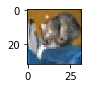

[3.71294737e+00 2.08728657e+01 1.19451225e-01 1.13248967e-01
 1.49048552e-01 1.20937042e-01 5.35881100e-03 2.74123549e-01
 2.98743019e+01 4.47577248e+01]
prediction : camion
label vrai : navire


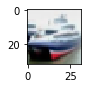

[1.2171538e+01 1.3042888e+01 3.2258359e-01 9.5142379e-02 2.8483748e-01
 1.0470454e-01 2.9052214e-03 4.7248775e-01 5.1628441e+01 2.1874472e+01]
prediction : navire
label vrai : navire


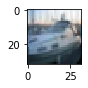

[41.203205    9.064403    5.906395    0.87335056  5.824803    0.99068636
  0.11135559  5.2211766  23.071293    7.733333  ]
prediction : avion
label vrai : avion


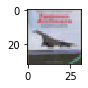

[ 1.2255074   0.1336054  22.18473     4.9373655  48.508972    4.426342
 14.964408    3.406211    0.10901166  0.10384714]
prediction : cerf
label vrai : grenouille


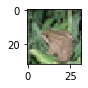

[ 4.356457   8.67972    7.4453006 22.69295   10.228435  10.815628
 23.47963    5.2403226  1.7715212  5.2900333]
prediction : grenouille
label vrai : grenouille


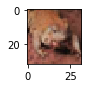

[ 1.1467668  2.5539525  2.3789623 42.482464   1.0080976 37.144016
  9.606899   0.9314143  1.191265   1.5561566]
prediction : chat
label vrai : auto


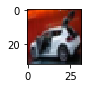

[ 1.2250997   0.1176265  29.965322    8.285306   21.830885    7.204783
 28.250381    2.7352374   0.16155331  0.2238139 ]
prediction : oiseau
label vrai : grenouille


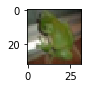

[16.802729    0.8526273  23.03819    15.686327    8.99901    21.549622
  2.37545     8.593862    1.3468175   0.75536436]
prediction : oiseau
label vrai : chat


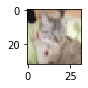

[9.9450487e-01 7.5558762e+01 1.1725705e-01 1.2945251e+00 2.8321214e-02
 9.5025647e-01 8.5088199e-01 1.3013287e-01 1.0099806e+00 1.9065380e+01]
prediction : auto
label vrai : auto


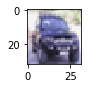

[16.628864    2.8726273   3.487826    6.034081    1.8586025   6.1755624
  0.43664092  0.23217076 61.729527    0.5440952 ]
prediction : navire
label vrai : avion


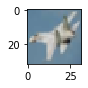

[ 0.89320356 37.191708    0.09645411  0.26265347  0.10866301  0.31012788
  0.0796712   0.29493853  4.071189   56.691395  ]
prediction : camion
label vrai : camion


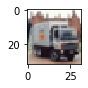

[ 2.8900967  1.8490599 11.995202  23.63616    6.774745  29.280949
 14.989889   5.75897    0.984503   1.8404268]
prediction : chien
label vrai : chien


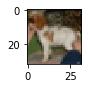

[ 8.318293  31.485134   3.8145368  3.8403797  3.106775   9.186021
  0.3442727 28.134827   3.1602998  8.60947  ]
prediction : auto
label vrai : cheval


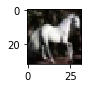

[ 5.2307825 31.625792   3.6416676  2.600017   3.604639   2.4746811
  3.3846724  6.1253996  3.4941483 37.818195 ]
prediction : camion
label vrai : camion


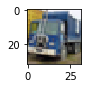

[ 4.501614    6.667143    1.4247155   2.5989437   2.8621306   2.375287
  0.18071751  0.6236612  76.063446    2.7023456 ]
prediction : navire
label vrai : navire


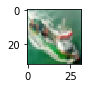

[ 2.430729   1.3445727  5.582143  18.421436   0.9971924 62.343407
  1.4615085  4.6474047  1.221654   1.5499554]
prediction : chien
label vrai : chien


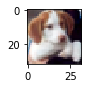

[ 4.930105  15.975101   7.188469  10.437194  11.302877   7.082454
  8.65589   15.670475   3.0179121 15.739528 ]
prediction : auto
label vrai : cheval


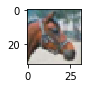

[1.5033550e+00 1.7216345e+00 1.6489023e-02 7.7123836e-02 2.1999847e-02
 3.8673948e-02 1.4997070e-04 6.7849047e-03 9.6096573e+01 5.1722091e-01]
prediction : navire
label vrai : navire


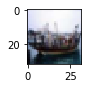

[8.5873103e-01 1.5717156e+00 1.2841217e+01 7.9260850e+00 5.7369385e+00
 9.4265022e+00 5.0688042e+01 1.0067031e+01 1.0639051e-02 8.7309748e-01]
prediction : grenouille
label vrai : grenouille


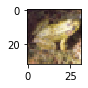

In [0]:
y_pred_proba = model.predict(X_test)*100
y_pred_bin=np.argmax(y_pred_proba,axis=-1)
y_pred = np_utils.to_categorical(y_pred_bin)

for i in range(0, 20):
    print(y_pred_proba[i])
    print("prediction : " + str(labels[int(y_pred_bin[i])]))
    print("label vrai : " + str(labels[int(Y_test_origin[i])]))
    plt.imshow(Image.fromarray(X_test_origin[i]),)
    #plt.imshow(toimage(X_test_origin[i]),)
    plt.show()
    


In [0]:
#matrice de confusion

conf = confusion_matrix(Y_test_origin,y_pred_bin)/1000*100
print(conf)

[[50.9  6.8  5.5  3.9  2.4  2.1  2.4  3.8 18.1  4.1]
 [ 4.1 65.1  0.1  2.   1.1  3.4  1.3  2.8  5.9 14.2]
 [10.5  4.1 25.1  8.8 16.6  8.6 13.1  7.8  3.4  2. ]
 [ 2.9  4.8  6.3 29.   5.2 22.4 15.5  5.7  3.6  4.6]
 [ 6.5  3.6 17.9  7.6 33.4  5.2 11.6  9.3  3.   1.9]
 [ 2.1  3.8  8.2 19.2  6.4 36.6  9.8  7.9  3.2  2.8]
 [ 0.7  3.4  6.7 12.4 13.8  4.6 52.7  2.8  1.4  1.5]
 [ 5.   4.6  5.4  7.   7.6  7.5  3.7 50.2  1.9  7.1]
 [ 8.5 12.6  1.1  2.3  1.8  2.7  0.7  1.2 61.8  7.3]
 [ 3.6 27.2  0.6  4.1  0.7  2.1  2.8  3.9  6.3 48.7]]


<Figure size 72x72 with 0 Axes>

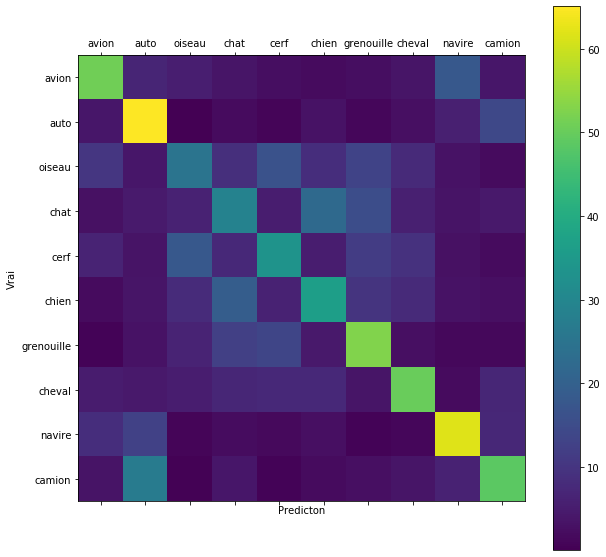

In [0]:
fig = plt.figure()
fig, ax = plt.subplots(figsize=(10,10))
cax = ax.matshow(conf)
fig.colorbar(cax)

ax.set_xlabel('Predicton')
ax.set_ylabel('Vrai')

yticks = [0,1,2,3,4,5,6,7,8,9]
xticks = [0,1,2,3,4,5,6,7,8,9]
ax.set_yticks(yticks)
ax.set_xticks(yticks)
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

plt.show()

#### Avec un réseau de neurone plus évolué : Un CNN (_Convolutional neural network_) 

Oui, car on est là 2 fois moins bon que les meilleurs qui atteignent les 98%. On va essayer un CNN : il s'agit d'utiliser des algorithmes dits de convolution qui sont des filtres chargés de mettre en évidence certaines caractéristiques des images puis des techniques de pooling pour réduire le nombre de paramètres à résoudre. 

![image.png](https://raw.githubusercontent.com/rst-analytics/atelier-ml/master/Capture5.JPG) 

(source Matlab - Introducing Deep Learning)

Voir https://hackernoon.com/visualizing-parts-of-convolutional-neural-networks-using-keras-and-cats-5cc01b214e59


#### Test avec un CNNS classique (modèles à 16 couches d'Oxford - VGG16)

Ce modèle est célèbre pour avoir gagné le challenge ImageNet 2014 (classification de 1000 classes sur 14 millions d'images, 92,7% de précision).



##### Le modèle (avec des optimisations agressives : Régularisation L2 + dropout)




A ce stade, il n'est pas nécessaire de discuter des techiques de régularisation ou de dropout. Ce sont des techniques d'optimisation permettant d'éviter ou de réduire l'_overfitting_ c'est-à-dire le sur-apprentissage : C'est ce qui apparaît lorsque le modèle est trop calqué sur les données d'apprentissage et est incapable de généraliser pour être efficace avec des données qu'il n'a jamais vu auparavant.  

![VGG](https://blog.keras.io/img/imgclf/vgg16_original.png) (source https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)




En savoir plus sur le modèle VGG16 (by VGG at Oxford under the Creative Commons Attribution License) :

* l'article “Very Deep Convolutional Networks for Large-Scale Image Recognition” de  K. Simonyan and A. Zisserman (University of Oxford) : https://arxiv.org/pdf/1409.1556https://arxiv.org/pdf/1409.1556  
* https://keras.io/applications/#vgg16





#### Implémentons le modèle

In [0]:
#Inspiré de https://github.com/geifmany/cifar-vgg/blob/master/cifar10vgg.py

from keras import regularizers
from keras.layers import BatchNormalization

model = Sequential()
weight_decay = 0.0005

model.add(Conv2D(64, (3, 3), padding='same',
                         input_shape=(32,32,3),kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

print(model.summary())
model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy,metrics=['accuracy'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_23 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_24 (Activation)   (None, 32, 32, 64)        0         
__

In [0]:
X_train2 = X_train_origin/255
X_test2 = X_test_origin/255


##### Utilisation d'un modèle pré-entrainé

Le modèle ci-dessus a été pré-entrainé par mes soins (sur une dizaine d'époques). La phase d'apprentissage est en effet très longue, il est donc illusoire aboutir à un résultat concluant en quelques dizaines de minutes. Il convient de charger les "poids" calculés du modèle puis de le jouer sur les données de test.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
model.load_weights("/content/gdrive/My Drive/docs/weight_vgg-11.h5") 



In [0]:
#training = model.fit(X_train2, Y_train, epochs=10, batch_size=32)

In [0]:
scores = model.evaluate(X_test2, Y_test, verbose=1)
print(scores)

10000/10000 [==============================] - 144s 14ms/step
[1.5163719818115233, 0.8042]


In [0]:
y_pred = model.predict(X_test2, verbose=1)
y_pred_bin=np.argmax(y_pred,axis=-1)
confusion_matrix(Y_test_origin,y_pred_bin)

10000/10000 [==============================] - 139s 14ms/step


array([[880,  26,  22,   5,  23,   0,  22,  16,   4,   2],
       [  4, 970,   0,   0,   0,   1,   6,   2,   0,  17],
       [ 53,   0, 622,  39, 113,  27, 105,  40,   0,   1],
       [ 19,   9,  12, 702,  41,  48,  94,  65,   0,  10],
       [  2,   0,   2,  31, 886,   3,  41,  35,   0,   0],
       [  4,   4,   7, 211,  42, 611,  38,  81,   0,   2],
       [  3,   2,   6,  30,   8,   5, 941,   5,   0,   0],
       [  5,   1,   5,  11,  33,  10,   3, 930,   0,   2],
       [138,  89,   2,   4,  26,   1,  46,   8, 647,  39],
       [ 24,  85,   2,   2,   2,   1,  16,  14,   1, 853]])

In [0]:
#matrice de confusion
conf = confusion_matrix(Y_test_origin,y_pred_bin)/1000*100
print(conf)

[[88.   2.6  2.2  0.5  2.3  0.   2.2  1.6  0.4  0.2]
 [ 0.4 97.   0.   0.   0.   0.1  0.6  0.2  0.   1.7]
 [ 5.3  0.  62.2  3.9 11.3  2.7 10.5  4.   0.   0.1]
 [ 1.9  0.9  1.2 70.2  4.1  4.8  9.4  6.5  0.   1. ]
 [ 0.2  0.   0.2  3.1 88.6  0.3  4.1  3.5  0.   0. ]
 [ 0.4  0.4  0.7 21.1  4.2 61.1  3.8  8.1  0.   0.2]
 [ 0.3  0.2  0.6  3.   0.8  0.5 94.1  0.5  0.   0. ]
 [ 0.5  0.1  0.5  1.1  3.3  1.   0.3 93.   0.   0.2]
 [13.8  8.9  0.2  0.4  2.6  0.1  4.6  0.8 64.7  3.9]
 [ 2.4  8.5  0.2  0.2  0.2  0.1  1.6  1.4  0.1 85.3]]


<Figure size 72x72 with 0 Axes>

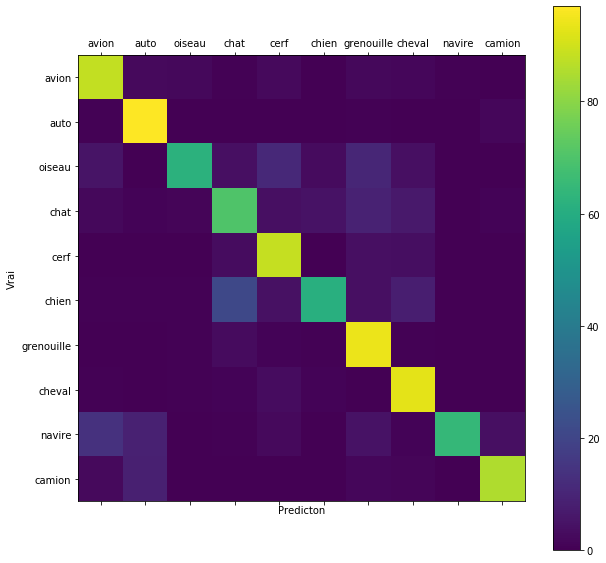

In [0]:
fig = plt.figure()
fig, ax = plt.subplots(figsize=(10,10))
cax = ax.matshow(conf)
fig.colorbar(cax)

ax.set_xlabel('Predicton')
ax.set_ylabel('Vrai')

yticks = [0,1,2,3,4,5,6,7,8,9]
xticks = [0,1,2,3,4,5,6,7,8,9]
ax.set_yticks(yticks)
ax.set_xticks(yticks)
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

plt.show()

##### Aller plus loin et faire mieux

Pour obtenir de meilleur résultats, il faudrait : 

* Entrainer les modèles sur plus d'époques
* Avoir plus de données en entrée
* Faire de la _data-augmentation_, c'est-à-dire générer des nouvelles images à partir des images existantes mais en modifiant les niveaux de zoom, en faisant quelques rotations ou des effets miroir etc. afin simuler de nouvelles images et d'aider le modèle à généraliser : En effet, si le modèle apprend à partir de données où tous les chats regardent vers la droite, pour lui, un chat qui regarde vers la gauche n'est pas un chat !! 
![image.png](https://blog.keras.io/img/imgclf/cat_data_augmentation.png) (source https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)



### Ok, en réalité ce n'est pas aussi simple

Il faut en effet en général passer du temps (beaucoup) pour : 
* Trouver les données
* Explorer et nettoyer les données
* Essayer différentes analyses, algorithmes, méthodes puis passer du temps à trouver les bons paramétrages
* Présenter convenablement les résultats de manière compréhensible par les non datascientistes en donnant la bonne information utile (transformable en actions concrètes)
* Et il existe beaucoup d'autres types d'algorithmes. Il n'est pas nécessaire de faire des réseaux de neurones ...

### Pour aller plus loin


* MOOC : L'excellente spécialisation Data Sciences de Johns Hopkins sur Coursera. https://fr.coursera.org/specializations/jhu-data-science. Une série de 10 MOOC pour apprendre les bases de R, (ré)apprendre quelques principes de bases de statistiques, de régression, de machines learning et pour réaliser quelques projets marrants 
* MOOC : La spécialisation Deep Learning sur Coursera https://fr.coursera.org/specializations/deep-learning . Une série de 5 MOOC géniaux avec Andrew NG, gourou international de l'IA, pour tout comprendre sur le Deep Learning ... et se familiariser avec Python
* Et bien d'autres MOOC ou ressources en ligne
* Un excellent livre (en français et en anglais) : 

![image.png](https://images-na.ssl-images-amazon.com/images/I/51%2BkYprYK1L._SX379_BO1,204,203,200_.jpg)


##### Pour en savoir plus : 

* https://www.college-de-france.fr/media/yann-lecun/UPL7915574462521283497_lecun_20160204_college_de_france_lecon_inaugurale.pdf
* https://www.college-de-france.fr/media/yann-lecun/UPL4485925235409209505_Intelligence_Artificielle______Y._LeCun.pdf
* https://cvernade.wp.imt.fr/files/2015/01/Introduction.pdf
* http://liris.cnrs.fr/christian.wolf/teaching/m2r/m2r-igi-machinelearning1.pdf